import pandas as pd
import json
import en_core_web_sm
import spacy
import gensim.parsing.preprocessing
import pprint

# Variables

input_path = '../../data/data_2021-02-01_22-27-13.862993.json'
output_path = '../../data/'

nlp = spacy.load("en_core_web_sm")
STOPWORDS = nlp.Defaults.stop_words

# Data loading and preparation

In [87]:
# Load data
with open(input_path, encoding="utf-8") as f:
    data = json.load(f)
# Extract keywords from every paper  
keywords_df = pd.json_normalize(data['papers'])['keywords']

print("No of papers: {}".format(keywords_df.shape[0]))

No of papers: 2230


In [89]:
def process(flat_words, lemmatize=True, min_word_len=2):
  flat_words = [gensim.parsing.preprocessing.strip_non_alphanum(word) for word in flat_words]
  doc = spacy.tokens.Doc(nlp.vocab, words=flat_words)

  processed = []

  if lemmatize:
    processed = [token.lemma_ for token in doc]
    processed = [token.lower() for token in processed]
  else:
    processed = [token.lower_ for token in doc]

  processed = [token for token in processed if token not in STOPWORDS]
  processed = [token for token in processed if len(token) >= min_word_len]

  return processed


In [90]:
def process_corpus(keywords_df, lemmatize=True, min_word_len=2):
  processed_corpus = []
  flat_words = []

  # n: no of research papers
  # [[kw11, kw12, ...] ...[kwn1, kwn2, kwn3, ...]]
  keywords = keywords_df.tolist()
  # j: no of document in which the keyword is present
  # kwji -> [wji1, wij2, ...] ~ list of all words associated with keyword i of paper j
  # [kwj1, kwj2, ...] -> [kwj11, kwj12, wkwj13, kwj21, kwj22, ...] ~ list of all words associated with the keywords of paper j
  for l in keywords:
    tmp = []
    for keyword in l:
      words = keyword.split(" ")
      for word in words:
        tmp.append(word)
    flat_words.append(tmp)

  for l in flat_words:
    processed_corpus.append(process(l, True, 2))

  return processed_corpus


In [91]:
from gensim import corpora

# Create BOW corpus
processed_corpus = process_corpus(keywords_df)
dictionary = corpora.Dictionary(processed_corpus)
num_docs = dictionary.num_docs
num_terms = len(dictionary.keys())

bow_corpus = [dictionary.doc2bow(words) for words in processed_corpus]


In [92]:
from gensim import models

# Train the model
tfidf = models.TfidfModel(bow_corpus)
# Create TFIDF corpus
tfidf_corpus = tfidf[bow_corpus]

In [93]:
from gensim import similarities

# Create cosine similarities matrix
index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary.token2id))

# Cosine similarity & Clustering

In [94]:
from collections import defaultdict

# Adapt threshold and then manually check the papers
# NOTE: papers that are above a 0.6 similarity
# share many words
def compute_similarities(processed_corpus, threshold=0.9):
  similarities = defaultdict(list)

  for query_doc_index in range(len(processed_corpus)):
    query_doc =  processed_corpus[query_doc_index]
    query_bow = dictionary.doc2bow(query_doc)
    sims = index[tfidf[query_bow]]
    for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
      if score >= threshold and document_number != query_doc_index:
        similarities[query_doc_index].append((document_number, score))

  return similarities


In [95]:
# Compute similarites between every two papers
sims = compute_similarities(processed_corpus, 0.0)

In [96]:
from collections import Counter
from math import floor
from tqdm import tqdm

avg_ws_thr = [0] * 11

last_mean = [0] *  11

# What the threshold levels mean
# NOTE: one would expect the number of words to increase
# as the threshold increases. This is not always the case as papers have different
# numbers of keywords.
for item in tqdm(sims.items()):
  curr_paper_ws = processed_corpus[item[0]]
  for paper in item[1]:
    if paper[0] > item[0]: 
      thr = (int) (floor(paper[1] * 10))
      paper_ws = processed_corpus[paper[0]]
      inter = list((Counter(curr_paper_ws) & Counter(paper_ws)).elements())
      last_mean[thr] += 1
      # Calculate rolling mean
      avg_ws_thr[thr] = avg_ws_thr[thr] + (len(inter) - avg_ws_thr[thr]) / last_mean[thr]

for thr in range(10):
  print("a 0.{}% similarity between papers coresponds to {} common words".format(thr, avg_ws_thr[thr]))
print("a 1.0% similarity between papers coresponds to {} common words".format(thr, avg_ws_thr[10]))

100%|██████████| 2230/2230 [00:39<00:00, 56.42it/s] 

a 0.0% similarity between papers coresponds to 0.2926255174554257 common words
a 0.1% similarity between papers coresponds to 2.0650985322495887 common words
a 0.2% similarity between papers coresponds to 2.899430443941645 common words
a 0.3% similarity between papers coresponds to 3.64901764901765 common words
a 0.4% similarity between papers coresponds to 4.3540856031128445 common words
a 0.5% similarity between papers coresponds to 5.097959183673468 common words
a 0.6% similarity between papers coresponds to 6.199999999999999 common words
a 0.7% similarity between papers coresponds to 7.933333333333334 common words
a 0.8% similarity between papers coresponds to 7.4 common words
a 0.9% similarity between papers coresponds to 10.2 common words
a 1.0% similarity between papers coresponds to 9 common words


In [97]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Calculate cosine distance for clustering
dist = cosine_distances(index)

In [98]:
# Cluster with the precomputed cosine distances matrix
# NOTE: do not perform dimensionality reduction. Choose DBSCAN because it is
# density based and does not require the number of clusters as parameter.
# NOTE: eps=0.3 seems to deliver the best results, even though it also produces many outliers.
def dbscan_cluster(eps=0.5):
    db = DBSCAN(
            eps=eps,
            min_samples=3,
            metric='precomputed',
            algorithm='brute').fit(dist)

    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print('Estimated number of clusters: %d' % n_clusters_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    #  Perform dimensional reduction of the distance matrix with PCA
    X = PCA(n_components=2).fit_transform(dist) 

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return db.labels_

Estimated number of clusters: 4


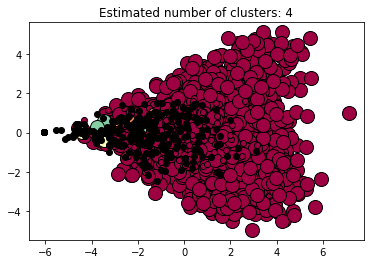

In [99]:
# Write labeled papers to json
clustered_papers = []
db_labels = dbscan_cluster(0.5)
keys = ['words', 'cluster']

for i in range(len(processed_corpus)):
    vals = [processed_corpus[i], int(db_labels[i])]
    clustered_papers.append(dict(zip(keys, vals)))


with open('../../data/' + '{}_labeled.json'.format(input_path.split('/')[-1][:-5]), 'w') as f:
        json.dump({'clustered_papers':clustered_papers}, f, ensure_ascii=False, indent=4)




# Visualization

In [100]:
clustered_papers = pd.DataFrame({'words': processed_corpus, 'cluster': db.labels_}, columns=['words', 'cluster'])

Text(0.5, 1.0, 'No of Words/Paper')

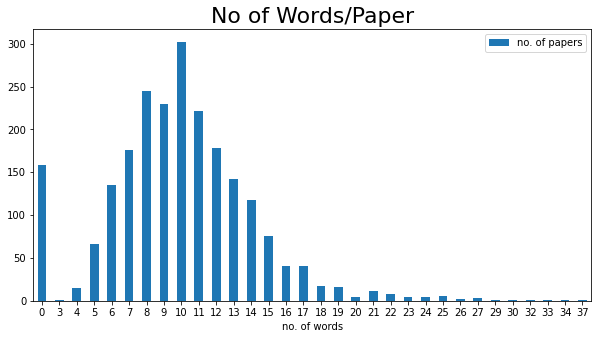

In [101]:
no_words = [len(words) for words in processed_corpus]
x = list(set(no_words))
_ = [no_words.count(tmp) for tmp in x]
df = pd.DataFrame({'no. of words': x, 'no. of papers':_})
ax = df.plot.bar(x='no. of words', y='no. of papers', rot=0, figsize=(10, 5))
plt.title("No of Words/Paper", fontsize=22)
#plt.savefig('words.png')

In [102]:
from collections import Counter

# Find most common words
c = Counter()
clustered_papers['words'].apply(c.update)
print(c.most_common(20))

[('learn', 890), ('model', 525), ('kernel', 304), ('optimization', 297), ('method', 255), ('network', 242), ('classification', 241), ('bayesian', 225), ('machine', 215), ('analysis', 204), ('regression', 200), ('process', 184), ('selection', 182), ('graph', 169), ('matrix', 167), ('datum', 165), ('inference', 163), ('algorithm', 158), ('linear', 140), ('vector', 136)]


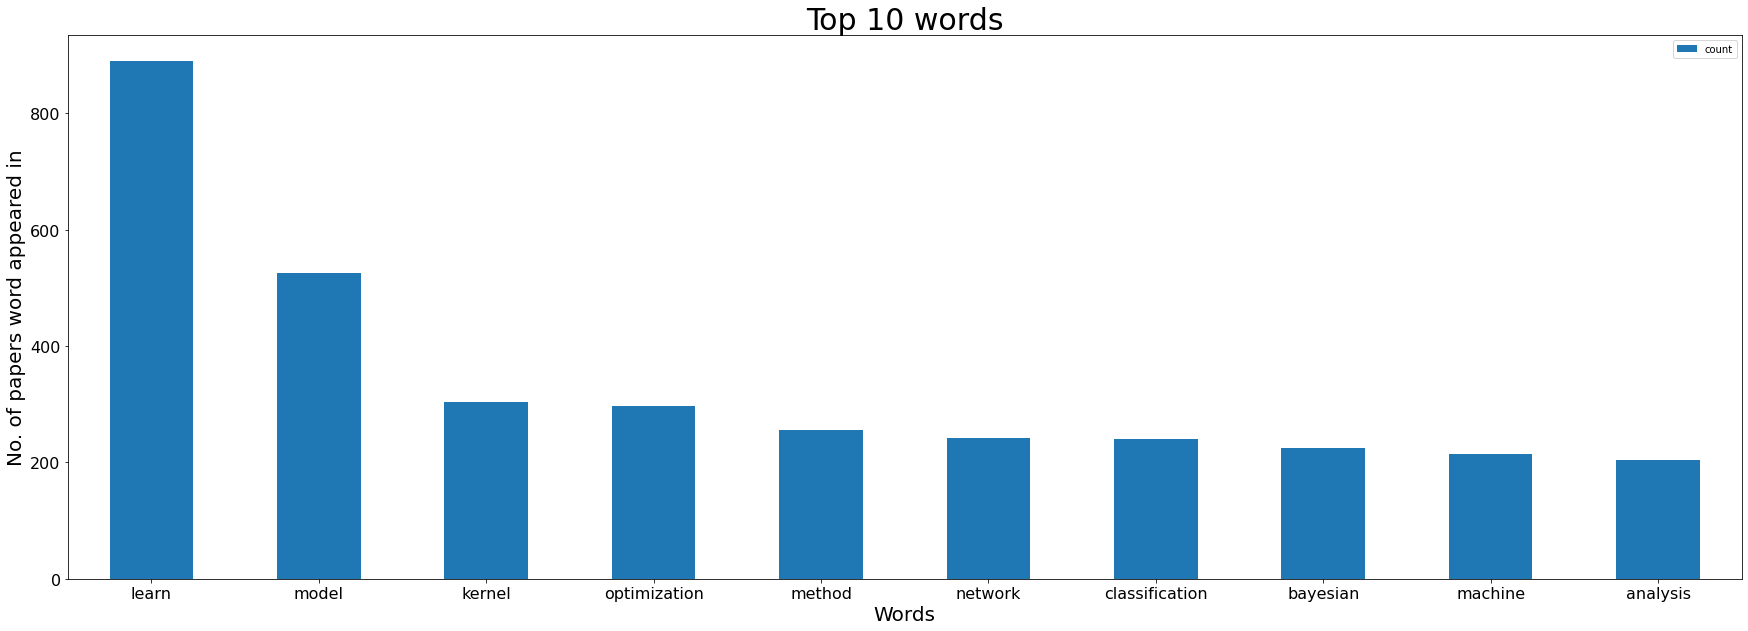

In [103]:
from matplotlib import ticker as mticker

df_counter_words = pd.DataFrame.from_dict(c, orient='index').reset_index()
df_counter_words = df_counter_words.rename(columns={'index':'word', 0:'count'})
top_words = df_counter_words.nlargest(10, "count")

top_plot = top_words.plot.bar(x='word', y='count', rot=0, fontsize= 16, figsize= (30, 10))
top_plot.set_xlabel("Words", fontsize= 20)
top_plot.set_ylabel("No. of papers word appeared in", fontsize= 20)
top_plot.set_title("Top 10 words", fontsize= 30)
top_plot.yaxis.set_major_formatter(mticker.ScalarFormatter())
top_plot.yaxis.get_major_formatter().set_scientific(False)
#plt.savefig(Path(output_directory +"words.png"))


In [104]:
top_40_words = df_counter_words.nlargest(40, 'count')

def count_words_paper(text):
    return len(list(set(text).intersection(list(top_40_words['word']))))

top_words_paper = clustered_papers['words'].apply(count_words_paper)


In [105]:
for i in range(max(top_words_paper + 1)):
    if i == max(top_words_paper):
        print("\nmax no. of words from top 40 present in a single paper is {}".format(max(top_words_paper)))
    print("{} papers have {} words from top 40".format(len(top_words_paper[top_words_paper == i]), i))

248 papers have 0 words from top 40
314 papers have 1 words from top 40
474 papers have 2 words from top 40
439 papers have 3 words from top 40
335 papers have 4 words from top 40
228 papers have 5 words from top 40
113 papers have 6 words from top 40
51 papers have 7 words from top 40
15 papers have 8 words from top 40
4 papers have 9 words from top 40
7 papers have 10 words from top 40
0 papers have 11 words from top 40
1 papers have 12 words from top 40
0 papers have 13 words from top 40

max no. of words from top 40 present in a single paper is 14
1 papers have 14 words from top 40


(-0.5, 399.5, 199.5, -0.5)

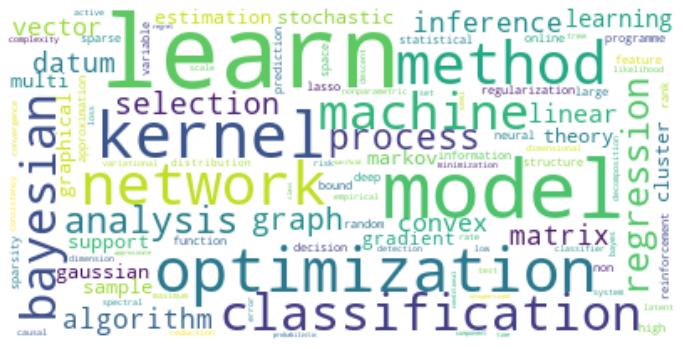

In [106]:
from wordcloud import WordCloud

joined_text = " ".join(clustered_papers.words.str.join(" ").tolist())

wordcloud = WordCloud(max_font_size=60, max_words=100, background_color="white", collocations=False).generate(joined_text)

fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.savefig(Path(output_directory + "top_keywords_wordcloud.png"))

In [107]:
vals = []

list_unique_labels = list(unique_labels)
for i in range(len(list_unique_labels)):
    _ = clustered_papers['words'][clustered_papers['cluster'] == list_unique_labels[i]].tolist()
    _ = [word for sublist in _ for word in sublist]
    vals.append(set(_))

words_label = pd.DataFrame({'words_set': vals, 'cluster': list_unique_labels}, columns = ['words_set', 'cluster'])

In [108]:
for index, row in words_label.iterrows():
    print("cluster {} contains {} unique words".format(row['cluster'], len(row['words_set'])))

cluster 0 contains 1880 unique words
cluster 1 contains 13 unique words
cluster 2 contains 33 unique words
cluster 3 contains 33 unique words
cluster 4 contains 21 unique words
cluster 5 contains 34 unique words
cluster 6 contains 15 unique words
cluster 7 contains 19 unique words
cluster 8 contains 20 unique words
cluster 9 contains 23 unique words
cluster 10 contains 16 unique words
cluster 11 contains 13 unique words
cluster 12 contains 24 unique words
cluster 13 contains 31 unique words
cluster 14 contains 11 unique words
cluster 15 contains 34 unique words
cluster 16 contains 40 unique words
cluster 17 contains 27 unique words
cluster -1 contains 2116 unique words


In [109]:
import itertools

common_words = []
common_words_no = []

for index, row in words_label.iterrows():
    cw_row = []
    cw_row_no = []
    for index_2, row_2 in words_label.iterrows():
        wset = list(set(row['words_set']).intersection(set(row_2['words_set'])))
        cw_row.append(wset)
        cw_row_no.append(len(wset))
    common_words.append(cw_row)
    common_words_no.append(cw_row_no)

In [110]:
clustered_papers['cluster'].value_counts(sort=True, ascending=True)


 17       3
 9        3
 7        3
 1        3
 11       3
 14       3
 16       3
 10       3
 8        3
 6        3
 12       3
 13       3
 4        5
 15       7
 3        7
 5        7
 2        7
-1      949
 0     1212
Name: cluster, dtype: int64

# KMEANS Clustering 

In [134]:
from gensim.matutils import corpus2dense, corpus2csc
from sklearn.cluster import KMeans

tfidf_corpus_dense = corpus2dense(tfidf_corpus, num_terms=num_terms, num_docs=num_docs)

In [139]:
# NOTE: cluster with kmeans to see if it delivers the same amout of clusters.
def kmeans_cluster(n_clusters=4):
    reduced_data = PCA(n_components=2).fit_transform(tfidf_corpus_dense.T)
    kmeans = KMeans(n_clusters=n_clusters, 
                    random_state=0).fit(reduced_data.astype('double'))

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation="nearest",
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired, aspect="auto", origin="lower")

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
                color="w", zorder=10)
    plt.title("K-means clustering on words dataset (PCA-reduced data)\n"
              "Centroids are marked with white cross")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    return kmeans.labels_

Estimated number of clusters: 38


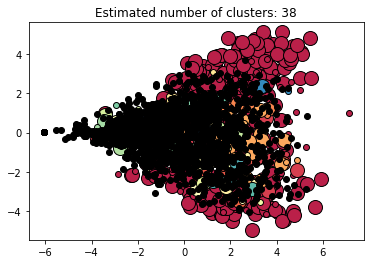

Estimated number of clusters: 18


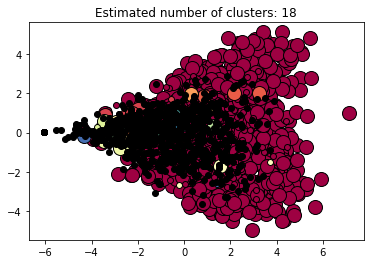

Estimated number of clusters: 4


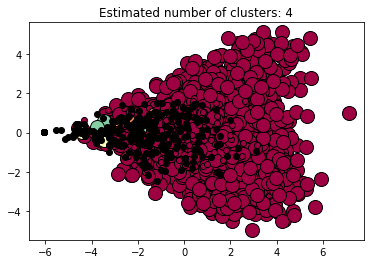

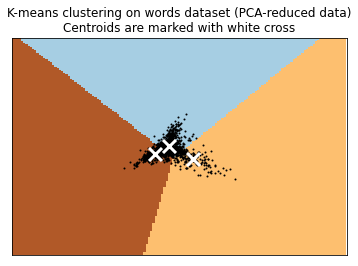

2230


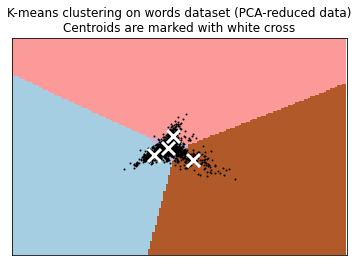

2230


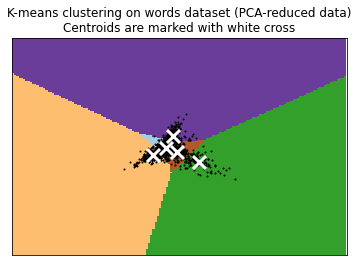

2230


In [162]:
db_eps = [0.3, 0.4, 0.5]
kmeans_ncluster = [3, 4, 5]
labels = [ [] for i in range(len(data['papers'])) ]

for eps in db_eps:
    _ = dbscan_cluster(eps)
    for i in range(len(_)):
        labels[i].append(int(_[i]))

for n_cluster in kmeans_ncluster:
    _ = kmeans_cluster(n_cluster)
    for i in range(len(_)):
        labels[i].append(int(_[i]))

In [163]:
keys =['dbscan_0.3','dbscan_0.4','dbscan_0.5','kmeans_3','kmeans_4','kmeans_5']

for i in range(len(data['papers'])):
    data['papers'][i]['label'] = dict(zip(keys, labels[i]))
    data['papers'][i]['token_kwords'] = processed_corpus[i]
        

In [164]:
with open('../../data/' + '{}_labeled.json'.format(input_path.split('/')[-1][:-5]), 'w') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)